### Programme principal
Ecriture du script py

In [15]:
%%writefile Cert_detect.py
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from LogGabor import LogGabor
import numpy as np
import time

# Init PyTorch arguments
parser = argparse.ArgumentParser(description='PyTorch MNIST detector from certainty map')
parser.add_argument('--batch_size', type=int, default=100, metavar='N',
                   help='training batch size used as input (default: 100)')
parser.add_argument('--epoch', type=int, default=10, metavar='N',
                   help='number of training epochs (default: 10)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                   help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no_cuda', action='store_true', default=False,
                   help='disables use of GPU acceleration (default: False)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                   help='random number seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                   help='how many batches to wait before logging training status (default: 50)')
args = parser.parse_args()
args.cuda = not args.no_cuda and torch.cuda.is_available() # check if GPU processing is available

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    #torch.cuda.empty_cache()
        
    
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {} # set some cuda parameters if cuda is activated

# Defining how the training data will be loaded
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
                batch_size=args.batch_size, 
                shuffle=True, 
                **kwargs)

# Defining how the test data will be loaded
eval_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', 
                   train=False,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
                batch_size=args.batch_size, 
                shuffle=True, 
                **kwargs)

# Defining the categorization neural network
class What(nn.Module):
    def __init__(self):
        super(What, self).__init__()
        self.conv1 = nn.Conv2d(1, 50, kernel_size=5)
        self.conv2 = nn.Conv2d(50, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(16820, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 16820)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Defining the localization neural network
class Where(nn.Module):
    # Defining the layers contained within the network
    def __init__(self):
        super(Where, self).__init__()
        self.conv1 = nn.Conv1d(1, 20, kernel_size=5)  # First convolutional layer        
        self.conv2 = nn.Conv1d(20, 50, kernel_size=5) # Second convolutional layer
        self.conv2_drop = nn.Dropout()                # Dropout layer (randomly zeroes some of the input elements)
        self.fc1 = nn.Linear(5850, 150)                # First linear layer (applies a linear transformation)
        self.fc2 = nn.Linear(150, 2)                   # Second linear layer
    
    # Defining the actions that'll be submitted to the network
    def forward(self, x):    
        x = F.relu(F.max_pool1d(self.conv1(x),2))                   # F.relu applies the rectified linear unit function element-wise
        x = F.relu(F.max_pool1d(self.conv2_drop(self.conv2(x)), 2)) # F.max_pool1d applies 1d max pooling over an input signal
        x = x.view(-1, 5850)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
    
def mnist_reshape_128(x, i_off=0, j_off=0):
    # Function that take a 28x28 pixels image and integrate it inside a blank 128*128 image
    # on coordinates defined by the i_off and j_off arguments
    N_pix = 28
    assert x.shape == (N_pix,N_pix)
    x_translate = np.zeros((N_pix*(128/N_pix), N_pix*(128/N_pix)))
    x_translate[(N_pix+22+i_off):(2*N_pix+22+i_off), (N_pix+22+j_off):(2*N_pix+22+j_off)] = x[2,-1]/(np.mean(x[2,-1]))
    return x_translate

def minmax(value, border):
    # Function that take a value and make sure it isn't superior
    # to a value defined by the border argument (or inferior of its inverse)
    value = max(value, -border)
    value = min(value, border)
    return value

def vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y):
    # Function that applies the LogPolar filter on an image, decreasing its resolution
    # with the excentricity compared to its center.
    # N_theta, N_orient, N_scale and N_phase define the filter shape
    phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    params= {'sf_0':.1, 'B_sf': lg.pe.B_sf, 'theta':np.pi* 5 / 7., 'B_theta': lg.pe.B_theta}
    phase = np.pi/4
    edge = lg.normalize(lg.invert(lg.loggabor(N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))
    
    for i_theta in range(N_theta):
        for i_orient in range(N_orient):
            for i_scale in range(N_scale):
                ecc =  .5**(N_scale - i_scale)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
                y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
                for i_phase in range(N_phase):
                    params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                    phase = i_phase * np.pi/2
                    phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            
    return phi

def train_classifier(epoch):
    t0 = time.time()
    model.train()
    
    for batch_idx, (data, LABEL) in enumerate(train_loader):
        if args.cuda:        
            LABEL = LABEL.cuda()           
        INPUT = data.min() * np.ones((args.batch_size, 1, 128, 128))

        for idx in range(args.batch_size):
            i_offset, j_offset = minmax(int(np.random.randn()*0), 2), minmax(int(np.random.randn()*0), 2)
            data_reshaped = mnist_reshape_128(data[idx,0,:], i_offset, j_offset)
            INPUT[idx, 0, :] = data_reshaped
            
        INPUT = torch.FloatTensor(INPUT)
        #normalize = transforms.Normalize((0.1307,), (0.3081,))
        INPUT, LABEL = Variable(INPUT), Variable(LABEL)
        if args.cuda: INPUT = INPUT.cuda()
        
        optimizer.zero_grad()
        
        OUTPUT = model(INPUT)
        
        loss = F.nll_loss(OUTPUT, LABEL)
        loss.backward()
        optimizer.step()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tElapsed time: {:.2f} mn'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0], (time.time()-t0)/60))

def eval_classifier(epoch):
    t0 = time.time()
    model.eval()
    eval_loss, correct = 0, 0
    for batch_idx, (data, LABEL) in enumerate(eval_loader):
        if args.cuda: 
            LABEL = LABEL.cuda() 
        LABEL = Variable(LABEL)
        INPUT = np.zeros((args.batch_size, 1, 128, 128))
        
        for idx in range(args.batch_size):
            i_offset, j_offset = minmax(int(np.random.randn()*0), 2), minmax(int(np.random.randn()*0), 2)
            data_reshaped = mnist_reshape_128(data[idx,0,:], i_offset, j_offset)
            INPUT[idx,0,:] = data_reshaped
            
        INPUT = torch.FloatTensor(INPUT)
        INPUT = Variable(INPUT)
        if args.cuda: INPUT = INPUT.cuda()
        
        OUTPUT = model(INPUT)
        eval_loss += F.nll_loss(OUTPUT, LABEL, size_average=False).data[0]
        pred = OUTPUT.data.max(1, keepdim=True)[1]
        correct += pred.eq(LABEL.data.view_as(pred)).cpu().sum()

    eval_loss /= len(eval_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Elapsed time: {:.2f} mn\n'.format(eval_loss, 
                                                                                 correct, 
                                                                                 len(eval_loader.dataset),
                                                                                 100. * correct / len(eval_loader.dataset),
                                                                                 (time.time()-t0)/60))
         
def map_classifier():
    t0 = time.time()
    t1 = time.time()
    model.eval()
    accuracy_map = np.zeros((128,128))

    for batch_idx, (data, LABEL) in enumerate(eval_loader):
        if args.cuda:
            LABEL = LABEL.cuda()
        LABEL = Variable(LABEL)

        for i_offset in range(-30, 30, 1):
            for j_offset in range(-30, 30, 1):
                pred, correct = 0, 0
                INPUT = np.zeros((args.batch_size,1,128,128))
                for idx in range(args.batch_size):
                    data_reshaped = mnist_reshape_128(data[idx,0,:], i_offset, j_offset)
                    INPUT[idx,0,:] =  data_reshaped

                INPUT = torch.FloatTensor(INPUT)
                INPUT = Variable(INPUT)
                if args.cuda:
                    INPUT = INPUT.cuda()

                OUTPUT = model(INPUT)
                pred = OUTPUT.data.max(1, keepdim=True)[1]
                correct = pred.eq(LABEL.data.view_as(pred)).sum()
                accuracy_map[i_offset+64-1][j_offset+64-1] += (correct / args.batch_size)
                if i_offset == 15 and j_offset == 15:
                    print(i_offset, j_offset, correct, accuracy_map[i_offset+64-1][j_offset+64-1])

                if time.time() - t1 > 30: 
                    print('i: {}, j: {}, elapsed time: {:.2f} mn'.format(i_offset, j_offset, (time.time()-t0)/60))
                    t1 = time.time()
        break
                
    return accuracy_map
        
            
model = What()
print('cuda:', args.cuda)
if args.cuda:
    model.cuda()
    
# Defining the optimizer that'll train the network
optimizer = optim.SGD(model.parameters(),
                      lr=args.lr,
                      momentum=args.momentum)

Overwriting Cert_detect.py


In [16]:
%run Cert_detect.py --epoch=3 --lr=5
path = 'Cert_detector.pt'

cuda: True


### Entrainement + Evaluation
Chargement des données si l'entrainement a déjà été réalisé.

In [2]:
import os
if os.path.isfile(path):
    print('Loading training values from', path)
    model.load_state_dict(torch.load(path))

else:
    print('Training...')
    for epoch in range(1, args.epoch+1):
        train_classifier(epoch)
        eval_classifier(epoch)
    torch.save(model.state_dict(), path)
    print('Training saved in', path)

Training...
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310353	Elapsed time: 0.02 mn
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.281910	Elapsed time: 0.14 mn
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.300485	Elapsed time: 0.25 mn
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.307182	Elapsed time: 0.37 mn
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.334751	Elapsed time: 0.48 mn
Train Epoch: 1 [25000/60000 (42%)]	Loss: 2.314589	Elapsed time: 0.59 mn
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.378581	Elapsed time: 0.71 mn
Train Epoch: 1 [35000/60000 (58%)]	Loss: 2.329533	Elapsed time: 0.82 mn
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.325985	Elapsed time: 0.94 mn
Train Epoch: 1 [45000/60000 (75%)]	Loss: 2.359250	Elapsed time: 1.05 mn
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.297672	Elapsed time: 1.16 mn
Train Epoch: 1 [55000/60000 (92%)]	Loss: 2.334803	Elapsed time: 1.28 mn
Test set: Average loss: 2.3221, Accuracy: 982/10000 (10%), Elapsed time: 0.10 mn

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.313906	Elap

### Evaluation seule

In [19]:
print('Evaluation...')
for epoch in range(1, args.epoch+1):
    eval_classifier(epoch)

Evaluation...

Test set: Average loss: 2.3015, Accuracy: 1135/10000 (11%), Elapsed time: 1.481396 mn


### Construction de la carte de certitude
Travail en cours

Accuracy map construction...
i: -15, j: -9, elapsed time: 0.50 mn
i: 0, j: -8, elapsed time: 1.00 mn
i: 15, j: 11, elapsed time: 1.50 mn
15 15 9 0.09
i: 24, j: 24, elapsed time: 2.00 mn


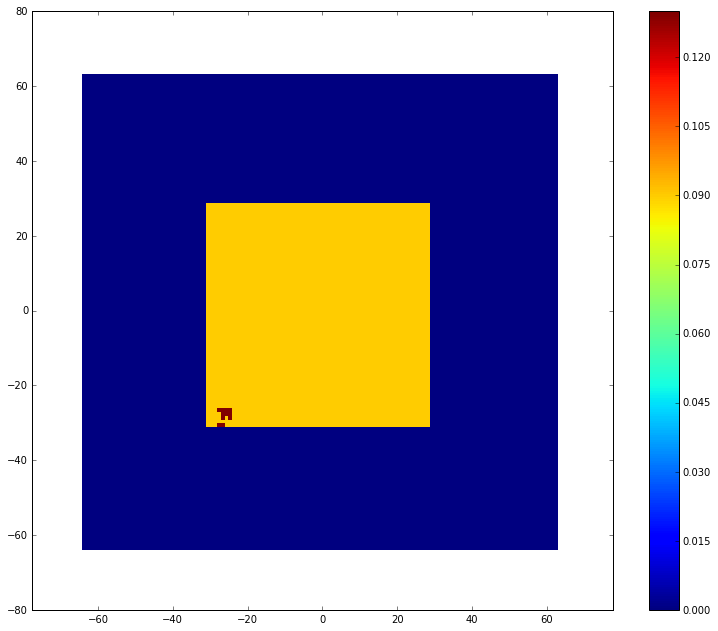

In [17]:
import matplotlib.pyplot as plt

print('Accuracy map construction...')
N_pix = 128//2
fig, ax = plt.subplots(figsize=(13, 10.725))
data = map_classifier()
cmap = ax.pcolor(np.arange(-N_pix, N_pix), np.arange(-N_pix, N_pix), data)
ax.axis('equal')
fig.colorbar(cmap)